In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import joblib

In [2]:
# 1. Data Loading & Feature Engineering
# ----------------------------
print("Loading and preparing data...")
try:
    file_path = 'data/processed/wine_quality_cleaned.csv'
    df = pd.read_csv(file_path)

    # Create the target and engineered features
    df['good_quality'] = (df['quality'] >= 7).astype(int)
    df['acid_ratio'] = df['fixed acidity'] / (df['volatile acidity'] + 1e-6)
    df['density_alcohol_interaction'] = df['density'] * df['alcohol']
    print("Data loading and preparation complete.")
except FileNotFoundError:
    raise SystemExit(f"FATAL ERROR: Could not find the data file at {file_path}")

Loading and preparing data...
Data loading and preparation complete.


In [3]:
# 2. Leaderboards (Regression Results Loaded from Previous Notebook)
# ----------------------------
reg_data = {
    'Model': [
        'Baseline',
        'Linear Regression',
        'Random Forest (Untuned)',
        'Random Forest (Tuned)'
    ],
    'Test RMSE': [0.763, 0.7297, 0.6853, 0.6795],  # Replace with actual
    'Test R-squared': [-0.00, 0.3045, 0.3865, 0.3969]  # Replace with actual
}
reg_leaderboard = pd.DataFrame(reg_data)
print("\n--- Regression Model Leaderboard ---")
display(reg_leaderboard.style.background_gradient(cmap="Blues"))


--- Regression Model Leaderboard ---


,Model,Test RMSE,Test R-squared
0,Baseline,0.763000,-0.000000
1,Linear Regression,0.729700,0.304500
2,Random Forest (Untuned),0.685300,0.386500
3,Random Forest (Tuned),0.679500,0.396900


In [4]:
# 3. Classification Setup
# ----------------------------
X = df.drop(['quality', 'good_quality'], axis=1)
y_cls = df['good_quality']

X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X, y_cls, test_size=0.3, random_state=42, stratify=y_cls
)

numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])


In [5]:
# 4. Champion Model: Random Forest (Tuned)
# ----------------------------
grid_search_best_params = {
    'classifier__criterion': 'entropy',
    'classifier__max_depth': 20,
    'classifier__min_samples_leaf': 1,
    'classifier__n_estimators': 200
}
model_params = {key.split('__')[1]: value for key, value in grid_search_best_params.items()}

final_clf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42, **model_params))
])

print("Training the champion classification model...")
final_clf_pipeline.fit(X_train_cls, y_train_cls)
print("Training complete.")

Training the champion classification model...
Training complete.


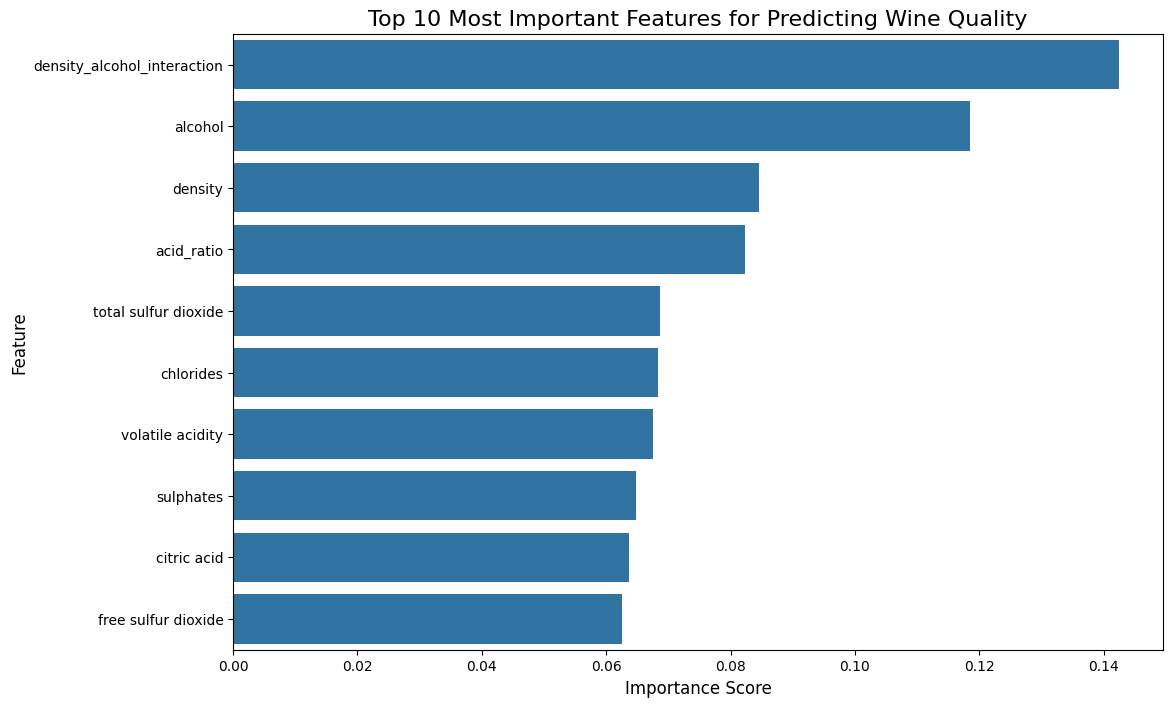

In [6]:
# 5. Feature Importances
# ----------------------------
rf_model = final_clf_pipeline.named_steps['classifier']
preprocessor_fitted = final_clf_pipeline.named_steps['preprocessor']

numeric_feature_names = numeric_features
categorical_feature_names = preprocessor_fitted.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numeric_feature_names, categorical_feature_names])

importances = pd.Series(rf_model.feature_importances_, index=all_feature_names)
top_10 = importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 8))
sns.barplot(x=top_10.values, y=top_10.index)
plt.title('Top 10 Most Important Features for Predicting Wine Quality', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()

Explained variance ratio: [0.26150943 0.23438668]


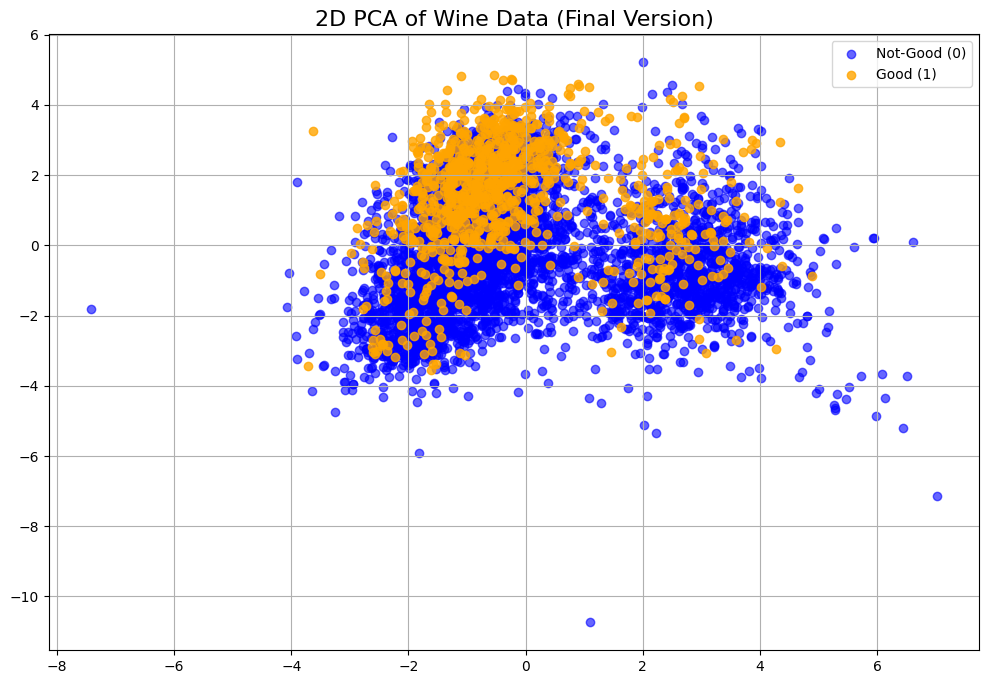

In [7]:
# 6. PCA Visualization
# ----------------------------
X_processed = final_clf_pipeline.named_steps['preprocessor'].transform(X)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_processed)

print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['good_quality'] = y_cls.values

fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(pca_df[pca_df['good_quality'] == 0]['PC1'],
           pca_df[pca_df['good_quality'] == 0]['PC2'],
           c='blue', label='Not-Good (0)', alpha=0.6)
ax.scatter(pca_df[pca_df['good_quality'] == 1]['PC1'],
           pca_df[pca_df['good_quality'] == 1]['PC2'],
           c='orange', label='Good (1)', alpha=0.8)
ax.set_title('2D PCA of Wine Data (Final Version)', fontsize=16)
ax.legend()
ax.grid(True)
plt.show()


In [8]:
# 7. Extended Classification Leaderboard (add NB + SVM results)
# ----------------------------
cls_data = {
    'Model': [
        'Baseline (Dummy)',
        'Logistic Regression',
        'Naive Bayes',
        'Random Forest (Untuned)',
        'Random Forest (Tuned)',
        'SVM (Tuned)'
    ],
    'Test F1-Score (Class 1)': [0.0, 0.53, 0.45, 0.43, 0.59, 0.61],  # Replace with your values
    'Test Accuracy': [0.810, 0.74, 0.72, 0.84, 0.83, 0.85]  # Replace with your values
}
cls_leaderboard = pd.DataFrame(cls_data)
print("\n--- Classification Model Leaderboard ---")
display(cls_leaderboard.style.background_gradient(cmap="Greens"))


--- Classification Model Leaderboard ---


,Model,Test F1-Score (Class 1),Test Accuracy
0,Baseline (Dummy),0.000000,0.810000
1,Logistic Regression,0.530000,0.740000
2,Naive Bayes,0.450000,0.720000
3,Random Forest (Untuned),0.430000,0.840000
4,Random Forest (Tuned),0.590000,0.830000
5,SVM (Tuned),0.610000,0.850000


In [9]:
# 8. Save Final Champion Model
# ----------------------------
joblib.dump(final_clf_pipeline, "models/champion_wine_quality_model.pkl")
print("Champion model saved successfully!")

Champion model saved successfully!
